# Adversarial neural networks for pivotal features
---
This example notebook illustrates the use of adverarial neural network architectures for constructing classifier variables which are pivotal with respect to/independent of certain other feature(s). The example uses a dataset from Ref. 1, which contains 5M hadronic jets characterised by their invariant mass in addition to five high-level jet substructure observables. The jets are either produced in the decay of a $W$ boson into a quark pair (signal, $y = 1$) or by the non-resonant emission of single partons (background, $y = 0$). This notebook will show, first, how to create a neural network $W$-boson jet classifier using the five jet substructure observables as input features and, second, how to use and adversarial neural network architecture to make this classifier indepedent of the jet mass.

### Further reading
1. Baldi et al., _Jet Substructure Classification in High-Energy Physics with Deep Neural Networks_ (2016) [arXiv: 1603.09349 [hep-ex]](http://arxiv.org/abs/1603.09349)
2. Louppe et al., _Learning to Pivot with Adversarial Networks_ (2017) [arXiv:1611.01046 [stat.ML]](https://arxiv.org/abs/1611.01046)
3. Shimmin et al., _Decorrelated Jet Substructure Tagging using Adversarial Neural Networks_ (2017) [arXiv:1703.03507 [hep-ex]](https://arxiv.org/abs/1703.03507)
4. ATLAS Collaboration, _Performance of mass-decorrelated jet substructure observables for hadronic two-body decay tagging in ATLAS_ (2018) [ATL-PHYS-PUB-2018-014](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PUBNOTES/ATL-PHYS-PUB-2018-014/)

![](business-and-spreadsheets.gif "segment")

## Setup
---
Import the necessary python modules and set the numpy's random number seed so as to ensure reproducible results.

In [1]:
# Import(s)
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# Set Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras import(s)
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam

# Local import(s) -- after Keras backend is set
import ops
import plots
import layers
reload(ops); reload(plots); reload(layers); 

# Reproducibility
np.random.seed(21)

/Users/asogaard/Library/Python/2.7/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/asogaard/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


Download the dataset. This assumes running on MacOS; if running on Linux replace `curl -O` $\to$ `wget`. If the file has already been downloaded, list it instead.

In [2]:
! if [ ! -f test_no_pile_5000000.h5 ]; then { curl -O http://www.igb.uci.edu/~pfbaldi/physics/data/hepjets/highlevel/test_no_pile_5000000.h5; }; else { ls -lrt test_no_pile_5000000.h5; }; fi

-rw-r--r--@ 1 asogaard  staff  140002144  7 Nov 08:05 test_no_pile_5000000.h5


Load the feature and target data from the downloaded file.

In [3]:
with h5py.File('test_no_pile_5000000.h5', 'r') as f:
    X = f["features"].value
    y = f["targets"].value.ravel()
    pass

# Clean-up
try: 
    del m
except NameError:
    pass

Extract the jet mass from the feature array, and perform some light filtering to make the task more well-defined and plots a bit prettier.

In [4]:
try:
    # Only do this once.
    m
except NameError:
    # Extract decorrelation variable (jet mass) from feature array
    m = X[:,0]
    X = X[:,1:]

    # Filter jet mass range
    msk_mass = (m >= 0) & (m <= 200)

    # Filter null entries
    msk_null = (np.sum(X == 0, axis=1) < 3)

    # Printing
    print "Filtering {:d} \"+\" {:d} entries from {:d} in total ({:.1f}%)."\
        .format((~msk_mass).sum(), (~msk_null).sum(), X.shape[0], 100.* (~msk_mass | ~msk_null).sum() / X.shape[0] )

    # Redefine arrays
    msk = msk_mass & msk_null
    X = X[msk]
    y = y[msk]
    m = m[msk]
    pass

Filtering 34643 "+" 148058 entries from 5000000 in total (3.4%).


Finally, define some common variables for convenience.

In [5]:
nb_samples  = 100000
nb_features = X.shape[1]

## Examining dataset
---
First, plot the jet mass distribution for the two classes of jets to illustrate the resonant peak of the signal ($W$-boson) jet mass spectrum and the continuum background.

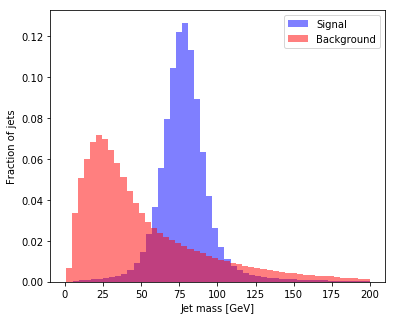

In [6]:
plots.distribution(y, m, xlabel="Jet mass [GeV]");

Then, plot the distributions of the five jet subtructure variables to illustrate the separating power.

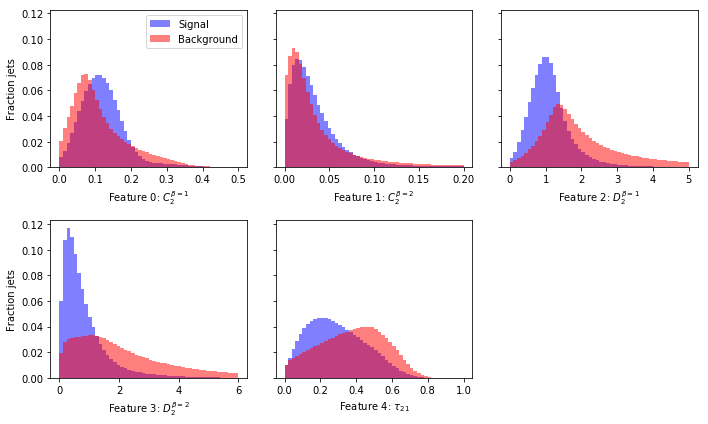

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(10,6), sharey=True)
ranges = [(0, 0.5), (0, 0.2), (0, 5.0), (0, 6.0), (0, 1.0)]
names  = ['$C_{2}^{\\beta=1}$', '$C_{2}^{\\beta=2}$', '$D_{2}^{\\beta=1}$', '$D_{2}^{\\beta=2}$', '$\\tau_{21}$']
for ix, (ax, rg, nm) in enumerate(zip(axes.flatten(), ranges, names)):
    bins = np.linspace(*rg, num=50 + 1, endpoint=True)
    plots.distribution(y, ix, X, bins=bins, xlabel='Feature {}: {:s}'.format(ix, nm), ylabel=' ', ax=ax, legend=(ix == 0))
    pass
fig.tight_layout()
axes[0][0].set_ylabel('Fraction jets')
axes[1][0].set_ylabel('Fraction jets')
fig.delaxes(axes.flatten()[-1])

## Stand-alone classification
---
Now we turn to training a simple binary jet classifier based on the above features. First, standardise the input features to have zero mean and unit width. This is essential for neural network performance.

In [8]:
X -= X.mean(axis=0)
X /= X.std (axis=0)

Split the dataset into a training and a testing set and subsample `nb_samples` entries from each to make the training run faster.

In [9]:
# Split dataset
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(X, y, m, train_size=nb_samples, random_state=1)

# Subsample 
X_test = X_test[:nb_samples]
y_test = y_test[:nb_samples]
m_test = m_test[:nb_samples]

Define factory method for constructing densely connected neural network classifiers with `nb_features` input features and a single output node, which produces a variable on the range [0,1] which is intepreted as the probability of a certain jet being signal, i.e. having label $y=1$ .

In [10]:
def classifier_model (nb_features):

    # Input(s)
    i = Input(shape=(nb_features,))
    
    # Hidden layer(s)
    x = Dense(16, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    
    # Output(s)
    o = Dense(1, activation='sigmoid')(x)    
    
    # Build model
    return Model(inputs=i, outputs=o, name='classifier')

Create an instance of the classifier network, compile it with binary cross-entropy loss, train it, and get predictions on the test set.

In [11]:
# Contruct classifier network
clf = classifier_model(nb_features)
clf.compile('adam', loss='binary_crossentropy')

# Model summary
clf.summary()

# Run training
hist_clf = clf.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Get test-set predictions for NN classifier
y_pred_NN = clf.predict(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 4s 44us/step - loss: 0.3881 - val_lo

Make a few plots to study the results of the stand-alone classifier training:
* Top left, the distribution of the NN classifier observable is shown for signal and background.

* Top right, the NN classifier is seen to improve classification dramatically compared to a threshold selection on either of the base substructure observables.

* Bottom left, however, the average value of the NN classifier observable is seen to be highly dependent on the jet mass; it is largest around the location of the $W$-boson mass peak, cf. the jet mass spectra above. This means that a threshold selection on the NN classifier observable will tend to scult the resulting background jet mass distribution.

* Bottom right, the jet mass distribution for background jets is shown for the full testing sample and for jets which pass a selection on the NN classifier at a 50% signal efficiency. This shows the sculpting effect — making the background passing the selection resemble the signal — which is what we want to use adversarial neural networks to avoid.

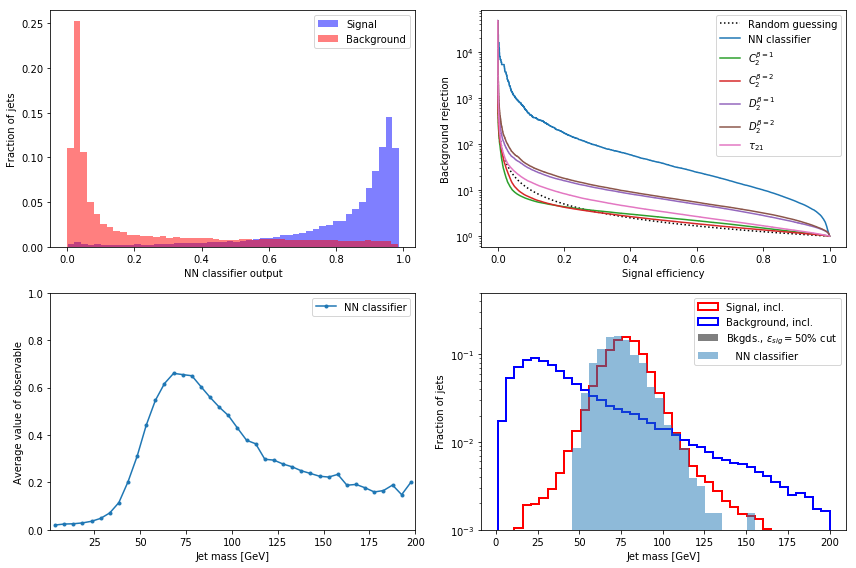

In [12]:
# Create axes
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()

# (1) Stand-alone NN classifier observable distributions
plots.distribution(y_test, y_pred_NN, xlabel="NN classifier output", ax=axes[0])

# (2) ROC curves
plots.roc(y_test, [y_pred_NN, None] + map(np.array, X_test.T.tolist()), ['NN classifier', None] + names, ax=axes[1])

# (3) Profile of average classifier observable versus jet mass for background jets
bkg = (y_test == 0)
plots.profile(m_test[bkg], y_pred_NN[bkg], 'NN classifier', ax=axes[2])

# (4) Jet mass distribution sculpting
plots.sculpting(m_test, y_test, y_pred_NN, 'NN classifier', ax=axes[3]);

fig.tight_layout()

## Adversarially trained classification
---
We now turn to the use of adversarial architectures to remove the jet mass-dependence observed above. Here, the classifier network is connected to an adversary, which takes the classifier output $z$ as its sole input. Based on $z$, the adversary tries to infer the jet mass $m$. This is done by letting the adverary parametrise a postieror p.d.f. in $m$ conditional on $z$ — i.e. $p_{\mathrm{adv}}(m\,|\,z)$ — as a Gaussian mixture model (GMM). The larger the p.d.f. value at the actual jet mass, the better the adversary is at inferring identifying the dependence of $z$ on $m$. If this is possible, the classifier is penalised so as to reduce this dependence.

The adversary is trained to maximise $p_{\mathrm{adv}}(m\,|\,z)$, and the gradient resulting from this optimisation is progated back through the classifier after applying a _gradient reversal operation_ at the connection between the two networks. This operation leaves $z$ unchanged in the forward pass, but scales the gradient by $-\lambda$ in the backward pass. This means that the gradient has the opposite effect on the classifier as on the adversary, meaning that for the classifier it makes the job of inferring $m$ from $x$ _harder_, i.e. it reduces the mass-dependence. During the adversaril training phase, the classifier is still trained to classify signal vs. background jets, and the magnitude of $\lambda$ therefore serves to balance the trade-off between the two objectives: classification and mass-decorrelation.

In this example, the adversarially trained neural network classifier (ANN) is considered as a minimal perturbation around the pre-trained classifier (NN). This is achieved by training the classifier with a much smaller learning rate than the adversary ($\times 10^{-8}$). Thereby, the classifier updates very slowly, and the adversary always has plenty of time to condition its posterior p.d.f. on $z$. 

This, however, is not necessary or necessarily optimal. Using the pre-trained classifier means that the adversary has to "undo" the initial sculpting, whereas starting from an un-trained classifier means that it would just have to discourage learning the sculpting in the first place. But it makes for a nice, direct comparison between NN and ANN classifiers which are directly related.

First, we define factory methods for the adversary network as well as for the combined classifier-plus-adversary network that we will use for the adversarial training. The adverary p.d.f. is actually on a transformed mass-variable, scaled to be confined to the interval [0,1]. This is simply to make life easier for the adversary. 

In [13]:
# Adversary factory method
def adversary_model (nb_gmm):

    # Input(s)
    i = Input(shape=(1,))
    m = Input(shape=(1,))
    
    # Hidden layer(s)
    x = Dense(4,  activation='relu')(i)
    x = Dense(8,  activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Gaussian mixture model (GMM) components
    coeffs = Dense(nb_gmm, activation='softmax') (x)  # GMM coefficients sum to one
    means  = Dense(nb_gmm, activation='sigmoid') (x)  # Means are on [0, 1]
    widths = Dense(nb_gmm, activation='softplus')(x)  # Widths are positive
    
    # Posterior p.d.f.
    pdf = layers.PosteriorLayer(nb_gmm)([coeffs, means, widths, m])

    # Build model
    return Model(inputs=[i,m], outputs=pdf, name='adversary')


# Combined factory method
def combined_model (clf, adv, lambda_reg, lr_ratio):

    # Classifier
    input_clf  = Input(shape=clf.layers[0].input_shape[1:])
    input_m    = Input(shape=(1,))
    output_clf = clf(input_clf)

    # Connect with gradient reversal layer
    gradient_reversal = layers.GradientReversalLayer(lambda_reg * lr_ratio)(output_clf)

    # Adversary
    output_adv = adv([gradient_reversal, input_m])

    # Build model
    return Model(inputs=[input_clf, input_m], outputs=[output_clf, output_adv], name='combined')

Define the custom loss function for the adversary. This is equivalent to binary cross-entropy loss for all $y = 1$, but we decide to specify it in this way to avoid confusion with binary classification and to point out the structure of the loss function: It simply maximises the adverary posterior p.d.f. in a way which mirrors the Kullback-Leibler divergence, which is a method for measuring mass-decorrelation direction. This will not be studied here, but see Ref. 4 above for details.

In [14]:
def KL (y_true, y_pred):
    """
    Kullback-Leibler loss; maximises posterior p.d.f.
    """
    return -K.log(y_pred)

Construct and compile the adversary and combined models, and print model summaries.

In [15]:
lam = 10.                     # Regularisation parameter, lambda
nb_gmm = 5                    # Number of GMM components
loss_weights = [1.0E-08, 1.]  # Relative learning rates for classifier and adversary, resp.
lr_ratio = loss_weights[0] / loss_weights[1]
optimiser = 'adam'            # Using the Adam optimiser

# Construct adverary model
adv = adversary_model(nb_gmm)
adv.compile(optimiser, loss=KL)

# Construct combined model
cmb = combined_model(clf, adv, lam, lr_ratio)
cmb.compile(optimiser, loss=['binary_crossentropy', KL], loss_weights=loss_weights)

# Model summaries
adv.summary()
cmb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 4)            8           input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 8)            40          dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 16)           144         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (D

Prepare sample weights for classifier and adversary losses, scale mass-variable to [0,1], and get predictions for the pre-trained, stand-alone NN classifier. Since we're concerned with the sculpting of the _background_ jet mas distribution, we only train compute adversary loss for background jets. Therefore, custom sampling weights are applied for the second loss, where the weight for all signal samples is set to zero, and the sum of weights is scale to be the same as for the classification loss.

In [16]:
# Prepare sample weights (i.e. only do mass-decorrelation for backround)
sample_weight = [np.ones(nb_samples, dtype=float), (y_train == 0).astype(float)]
sample_weight[1] *= np.sum(sample_weight[0]) / np.sum(sample_weight[1])

# Rescale jet mass to [0,1]
mt_train  = m_train - m_train.min()
mt_train /= mt_train.max()

# Get classifier predictions
z_train = clf.predict(X_train)

First, we condition the adversary on the pre-trained NN classifier. This is both to give it a good start and to illustrate how the adversary posterior p.d.f. works.

In [17]:
hist_adv = adv.fit([z_train, mt_train], np.ones_like(mt_train), sample_weight=sample_weight[1], epochs=5, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/5
80000/80000 [==============================] - 11s 138us/step - loss: -1.5911 - val_loss: -2.0882
Epoch 2/5
80000/80000 [==============================] - 9s 109us/step - loss: -2.3543 - val_loss: -2.4443
Epoch 3/5
80000/80000 [==============================] - 8s 105us/step - loss: -2.5205 - val_loss: -2.5224
Epoch 4/5
80000/80000 [==============================] - 9s 107us/step - loss: -2.5668 - val_loss: -2.5462
Epoch 5/5
80000/80000 [==============================] - 10s 123us/step - loss: -2.5973 - val_loss: -2.5782


Now, we can try to plot $p_{\mathrm{adv}}(m\,|\,z)$ for a few different values and overlay these p.d.f.s on the background jet mass distributions, both inclusively and in bins of $z$ around these values. The plot on the right shows how the adverary is able to accurately learn the distribution of $m$ given $z$. It is this ability we will use in the adversarial training.

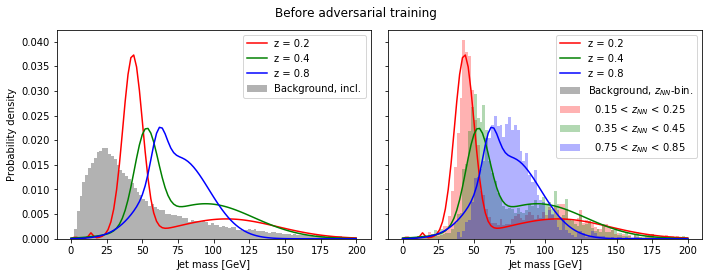

In [18]:
plots.posterior(adv, m_train[y_train == 0], z_train[y_train == 0], title='Before adversarial training');

Then we can perform the simultaneous, adversarial training of the classifier and adversary. This is a delicate procedure and is a bit time consuming due to the small learning rate for the classifier and the desire for a stable result.

In [19]:
hist_cmb = cmb.fit([X_train, mt_train], [y_train, np.ones_like(mt_train)], sample_weight=sample_weight, epochs=100, validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 11s 138us/step - loss: -1.1004 - classifier_loss: 0.5560 - adversary_loss: -1.1004 - val_loss: -0.9993 - val_classifier_loss: 0.5935 - val_adversary_loss: -0.9993
Epoch 2/100
80000/80000 [==============================] - 11s 135us/step - loss: -0.9952 - classifier_loss: 0.6068 - adversary_loss: -0.9952 - val_loss: -0.9607 - val_classifier_loss: 0.6262 - val_adversary_loss: -0.9607
Epoch 3/100
80000/80000 [==============================] - 11s 139us/step - loss: -0.9745 - classifier_loss: 0.6060 - adversary_loss: -0.9745 - val_loss: -0.9687 - val_classifier_loss: 0.6032 - val_adversary_loss: -0.9687
Epoch 4/100
80000/80000 [==============================] - 11s 139us/step - loss: -0.9880 - classifier_loss: 0.5974 - adversary_loss: -0.9880 - val_loss: -0.9936 - val_classifier_loss: 0.6010 - val_adversary_loss: -0.9936
Epoch 5/100
80000/80000 [==============================] - 12s

80000/80000 [==============================] - 13s 159us/step - loss: -1.0137 - classifier_loss: 0.5385 - adversary_loss: -1.0137 - val_loss: -0.9973 - val_classifier_loss: 0.5458 - val_adversary_loss: -0.9973
Epoch 38/100
80000/80000 [==============================] - 12s 153us/step - loss: -1.0142 - classifier_loss: 0.5388 - adversary_loss: -1.0142 - val_loss: -0.9978 - val_classifier_loss: 0.5422 - val_adversary_loss: -0.9978
Epoch 39/100
80000/80000 [==============================] - 11s 139us/step - loss: -1.0161 - classifier_loss: 0.5378 - adversary_loss: -1.0161 - val_loss: -1.0011 - val_classifier_loss: 0.5390 - val_adversary_loss: -1.0011145 - classifier_loss: 0.5383
Epoch 40/100
80000/80000 [==============================] - 12s 144us/step - loss: -1.0144 - classifier_loss: 0.5354 - adversary_loss: -1.0144 - val_loss: -1.0011 - val_classifier_loss: 0.5380 - val_adversary_loss: -1.0011
Epoch 41/100
80000/80000 [==============================] - 10s 130us/step - loss: -1.0134 -

Epoch 74/100
80000/80000 [==============================] - 13s 162us/step - loss: -1.0145 - classifier_loss: 0.5337 - adversary_loss: -1.0145 - val_loss: -0.9991 - val_classifier_loss: 0.5431 - val_adversary_loss: -0.9991
Epoch 75/100
80000/80000 [==============================] - 11s 139us/step - loss: -1.0175 - classifier_loss: 0.5378 - adversary_loss: -1.0175 - val_loss: -1.0001 - val_classifier_loss: 0.5480 - val_adversary_loss: -1.0001
Epoch 76/100
80000/80000 [==============================] - 12s 155us/step - loss: -1.0168 - classifier_loss: 0.5373 - adversary_loss: -1.0168 - val_loss: -1.0024 - val_classifier_loss: 0.5454 - val_adversary_loss: -1.0024
Epoch 77/100
80000/80000 [==============================] - 14s 171us/step - loss: -1.0156 - classifier_loss: 0.5353 - adversary_loss: -1.0156 - val_loss: -1.0019 - val_classifier_loss: 0.5475 - val_adversary_loss: -1.0019
Epoch 78/100
80000/80000 [==============================] - 14s 176us/step - loss: -1.0182 - classifier_loss

Once that's done, we can get a new set of (A)NN classifier observable values.

In [20]:
z_train    = clf.predict(X_train)
y_pred_ANN = clf.predict(X_test)

Using these, we can perform a similar study as above of the adverary posterior p.d.f. compared to background jet mass distributions in slices of $z$. Hopefully you should see that the slices are now much closer together, indicating a reduction in mass-dependence.

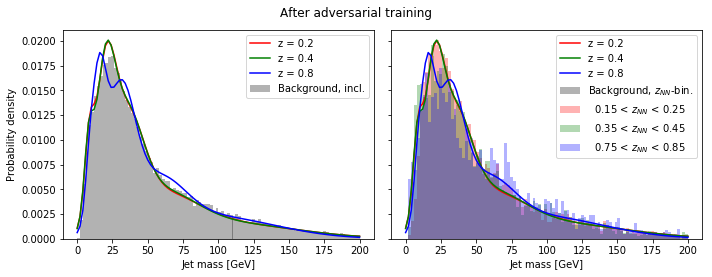

In [21]:
plots.posterior(adv, m_train[y_train == 0], z_train[y_train == 0], title='After adversarial training');

Finally, we can make the same plots as we did above for the NN classifier.

* Top left, we still see good separation of signal and background jets.
* Top right, however the classification performance of the ANN classifier is significantly degraded relative to the NN classifier.
* Bottom left, the flip-side of that is that tthe average ANN observable is all but constant as a function of the jet mass.
* Bottom right, and there is little mass-sculpting for the ANN classifier.

This shows the effect of the adversarial training for jet classification, and the trade-off between classification and a pivotal classification observable must be made on a case-by-case basis.

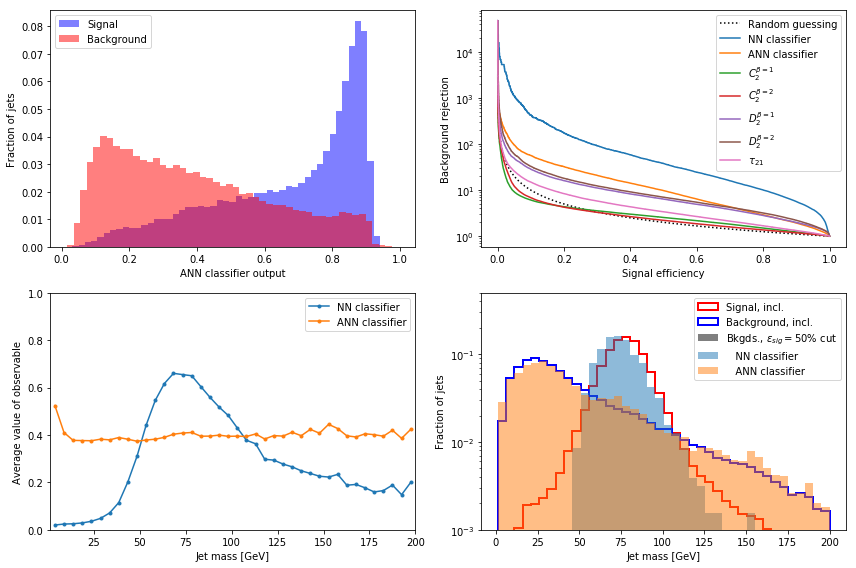

In [22]:
# Create axes
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()

# (1) Stand-alone NN classifier observable distributions
plots.distribution(y_test, y_pred_ANN, xlabel="ANN classifier output", ax=axes[0])

# (2) ROC curves
plots.roc(y_test, [y_pred_NN, y_pred_ANN] + map(np.array, X_test.T.tolist()), ['NN classifier', 'ANN classifier'] + names, ax=axes[1])

# (3) Profile of average classifier observable versus jet mass for background jets
bkg = (y_test == 0)
plots.profile(m_test[bkg], [y_pred_NN[bkg], y_pred_ANN[bkg]], labels=['NN classifier', 'ANN classifier'], ax=axes[2])

# (4) Jet mass distribution sculpting
plots.sculpting(m_test, y_test, [y_pred_NN, y_pred_ANN], ['NN classifier', 'ANN classifier'], ax=axes[3]);

fig.tight_layout()